In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [5]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2') #'binary_cl2_1e36_RANDOM'

In [6]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 300, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 0, 'dividing_factor': 10, 'output_channels_mlp': 800, 'n_channels1_cnn': 400, 'n_channels2_cnn': 600, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f82b4310790>, <dataset.data.SmartNegAugment object at 0x7f82b434b670>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f82b4346fd0>, <dataset.data.SmartNegAugment object at 0x7f82b4346d30>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [7]:
#args_dict['policies_train'][0].height_probabilities

In [8]:
#args_dict['policies_train'][0].height_bins

In [9]:
file_train = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train_original = pickle.load(fp)

file_train = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "RANDOM", "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [10]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', 'val500.csv'))
assert test500.couples.isin(gene_pairs_test).all()

In [11]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'val_results500.csv'))

# Drop all the pairs (they should be 60-70) that are present in the training set.
res = res[~res.couples.isin(gene_pairs_train_original)]

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     30471
           1       0.47      0.54      0.50     14373

    accuracy                           0.66     44844
   macro avg       0.62      0.63      0.62     44844
weighted avg       0.67      0.66      0.67     44844



# PLOTS

In [12]:
def balance_df(df, n_iter = 25):
    toappend = []
    if df[df.ground_truth == 0].shape[0] > df[df.ground_truth == 1].shape[0]:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
    else:
        for i in range(n_iter):
            negs = df[df.ground_truth == 0]
            poss = df[df.ground_truth == 1]
            toappend.append(pd.concat([poss.sample(len(negs)), negs], axis = 0))
    balanced = pd.concat(toappend, axis = 0)
    return balanced

### Log plots

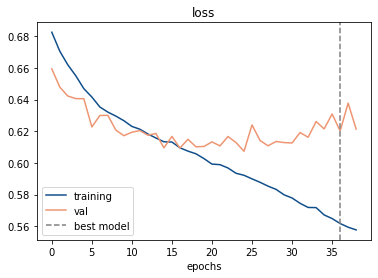

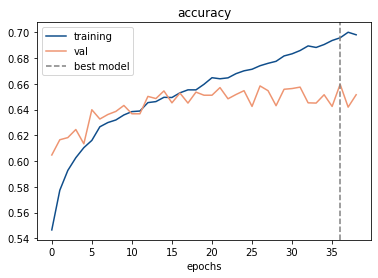

In [13]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [14]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    28455
1    16389
Name: prediction, dtype: int64


0    30471
1    14373
Name: ground_truth, dtype: int64


In [15]:
n_conf = 10

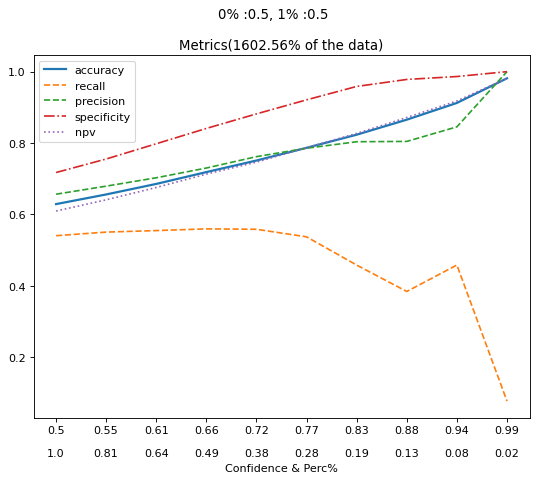

In [16]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

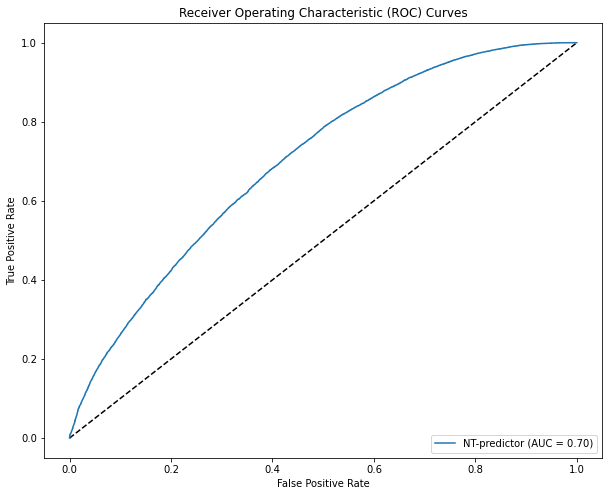

In [17]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

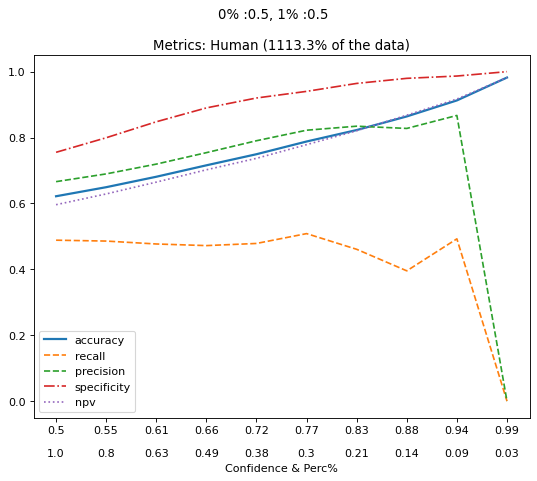

In [18]:
human = res[(res.specie == 'human')]
obtain_plot(balance_df(human), n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

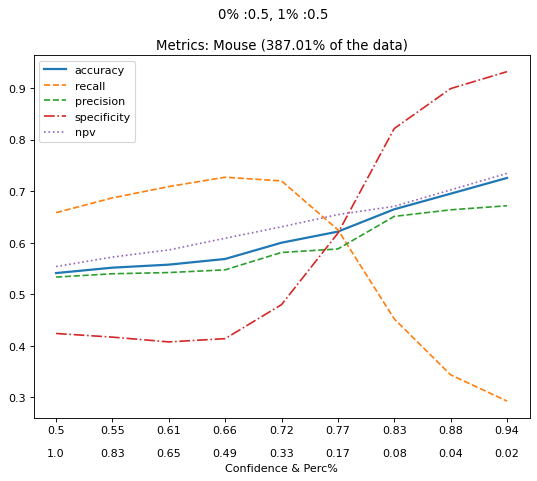

In [19]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(balance_df(mouse), n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

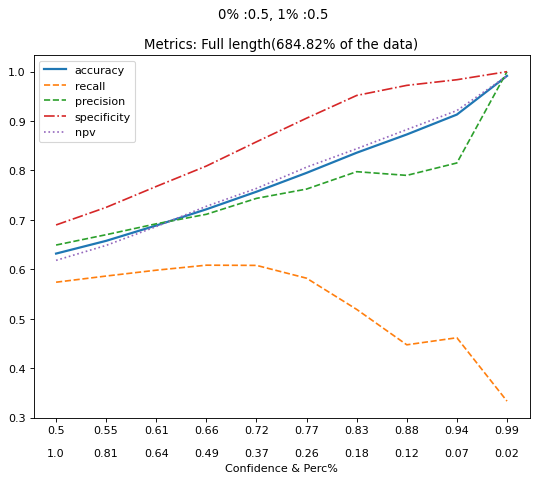

In [20]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(balance_df(full_length), n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

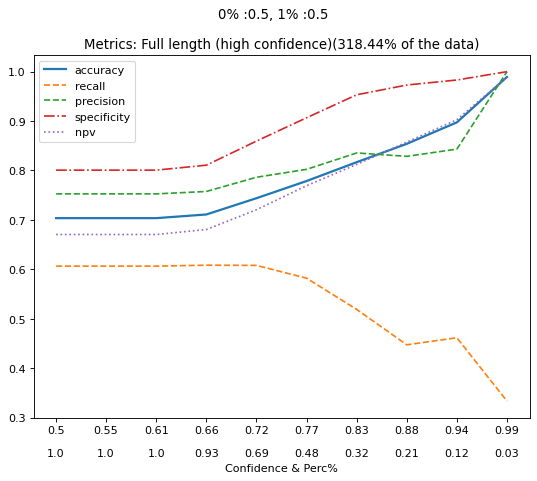

In [21]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(balance_df(high_conf_fl), n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [22]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

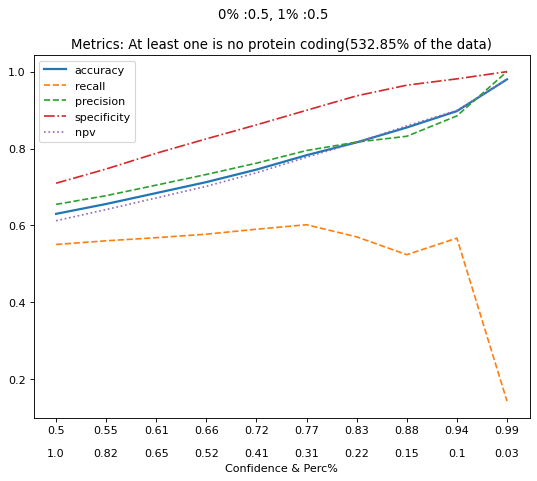

In [23]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.6716141001855288


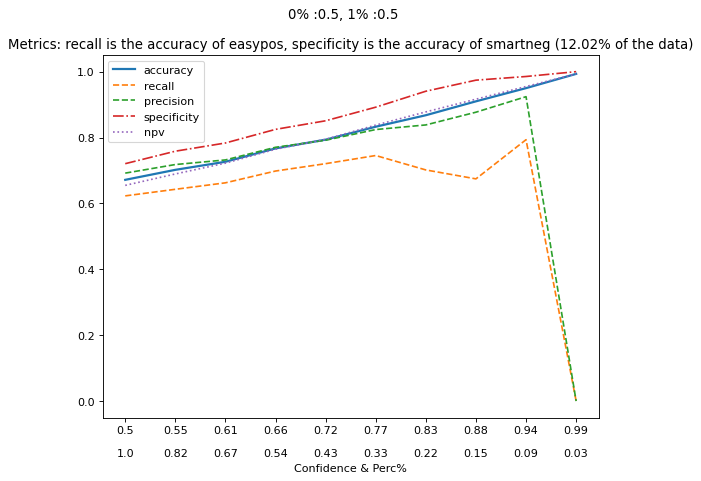

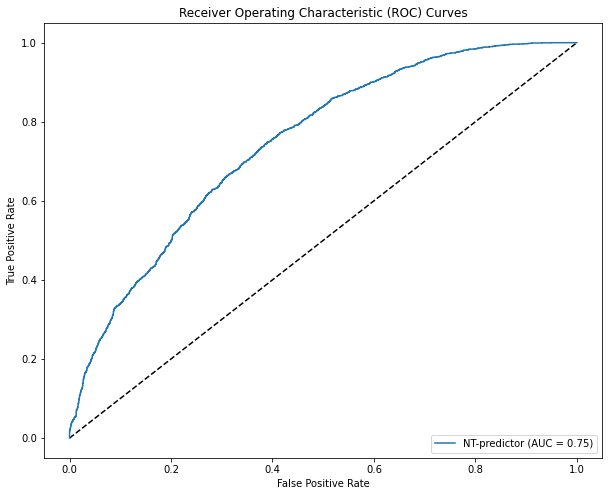

In [24]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_val_sampled_nt.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
easypos_smartneg_HQ = res[res.id_sample.isin(subset_test_nt_sampled)]

# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg_HQ
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

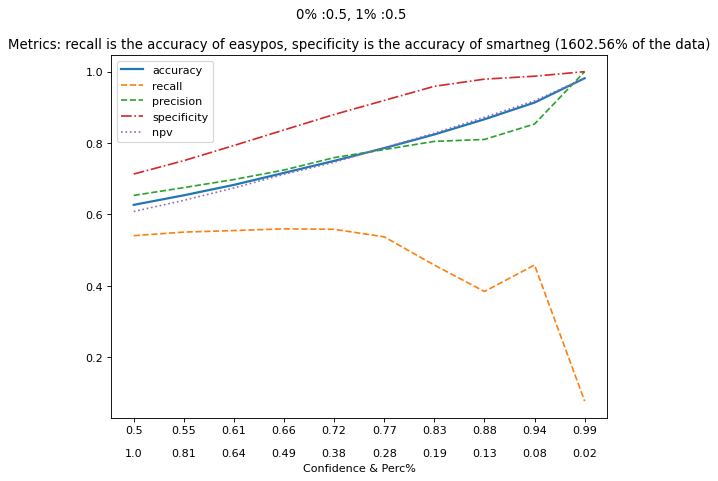

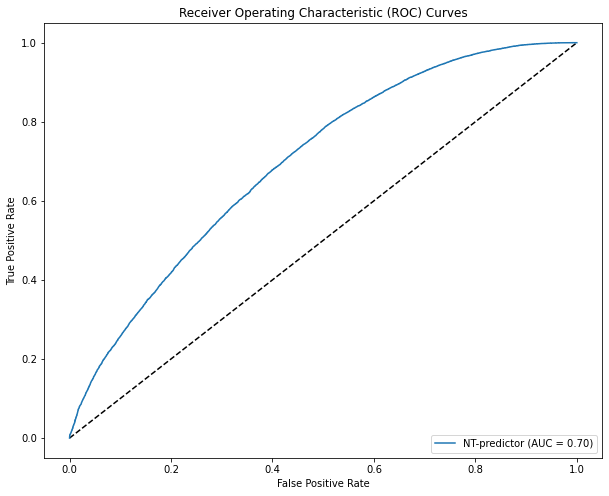

In [25]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_val.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
all_val = res[res.couples.isin(subset_test_nt_sampled)]
assert all_val.shape[0] == res.shape[0]
easypos_smartneg = all_val[all_val.policy.isin(['smartneg', 'easypos'])]


obtain_plot(balance_df(easypos_smartneg), n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT-predictor'}], easypos_smartneg.ground_truth)

Text(0, 0.5, 'Accuracy SmartNeg VS EasyPos')

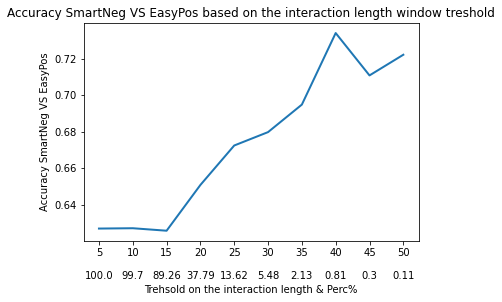

In [26]:
def obtain_acc_and_perc(treshold, res, test500):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    accuracies.append(acc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

0.7109458023379384


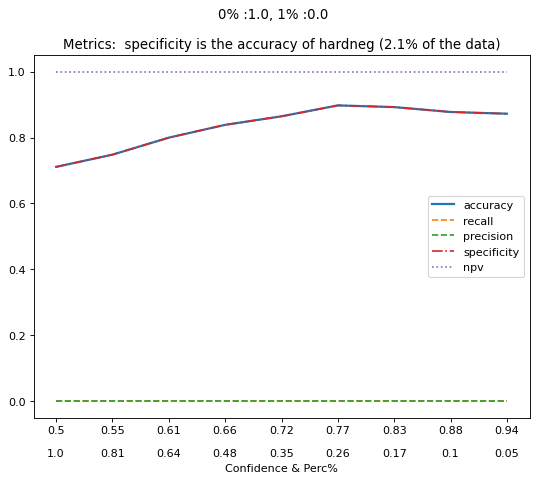

In [27]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8200663349917081


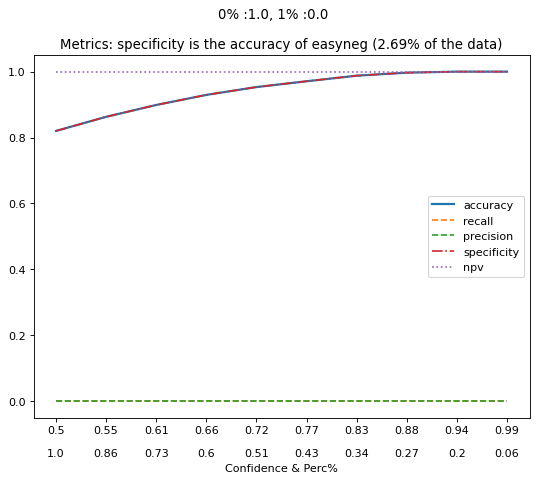

In [28]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

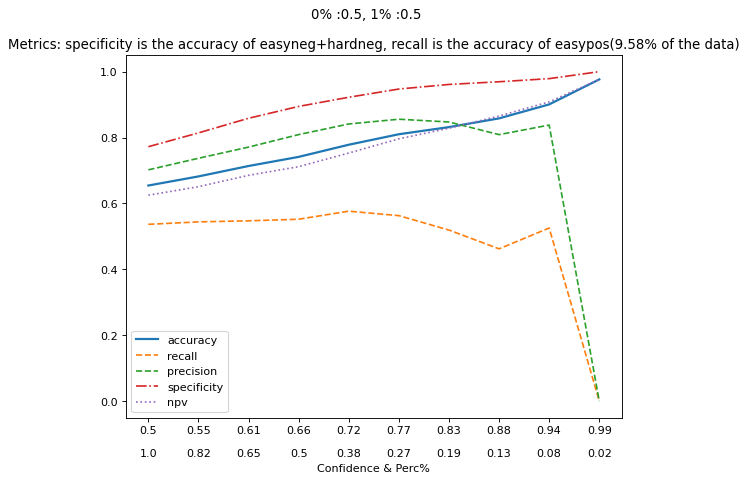

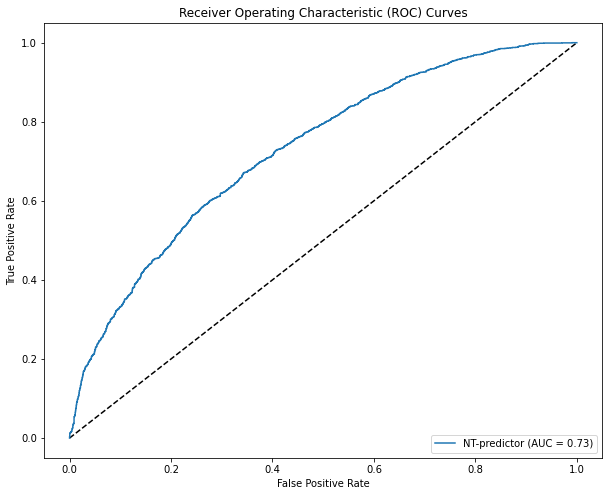

In [29]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

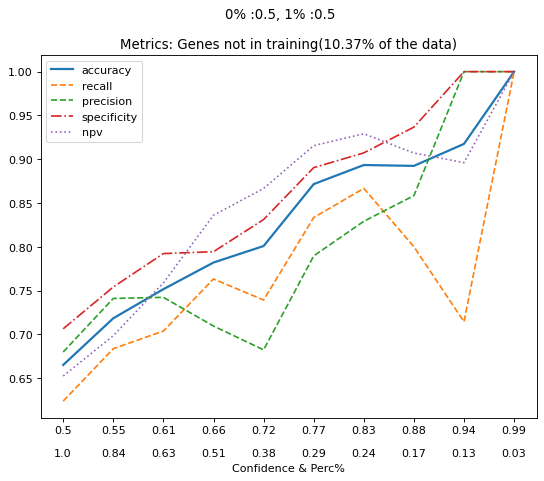

In [30]:
df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(balance_df(not_in_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

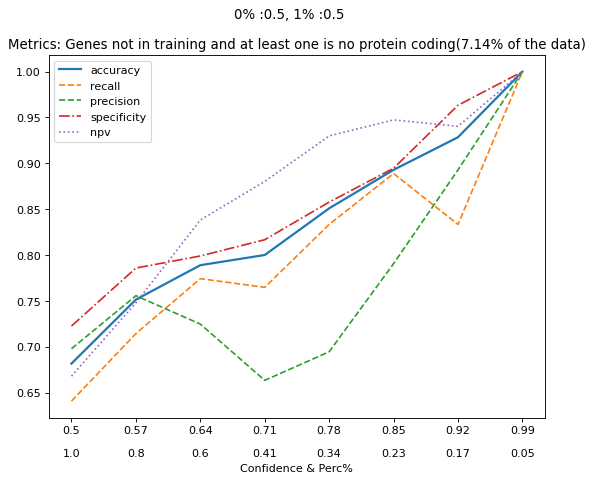

In [31]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(balance_df(no_pc_no_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

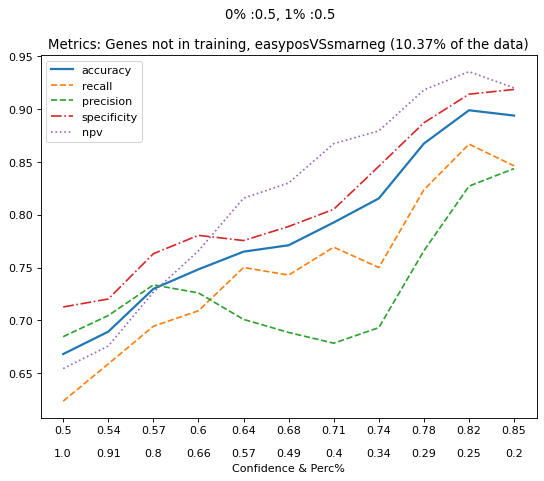

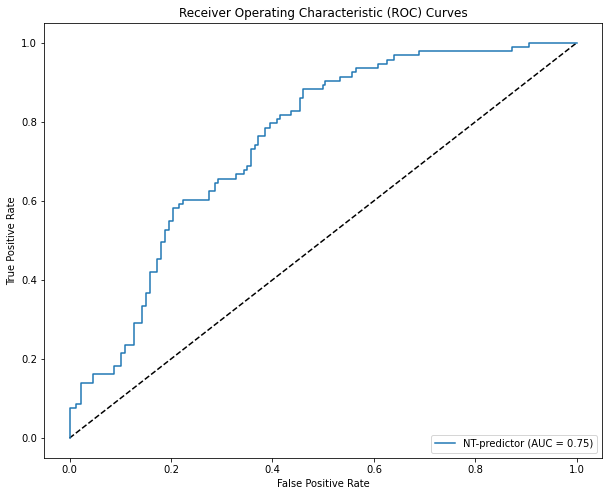

In [33]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
not_in_train_epsn_balanced = balance_df(not_in_train_epsn)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

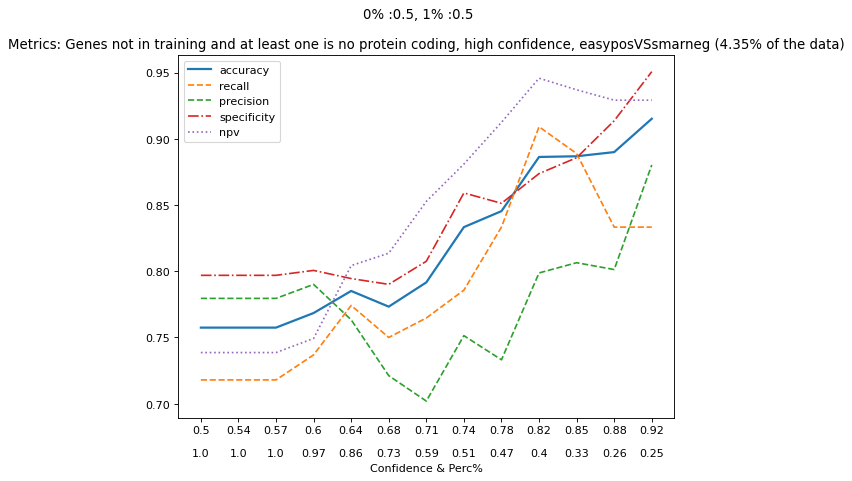

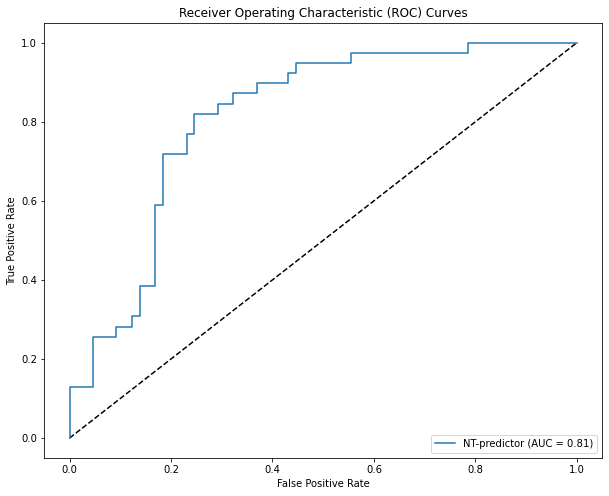

In [34]:
confidence_level = 0.6

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]

obtain_plot(balance_df(no_pc_no_train), n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

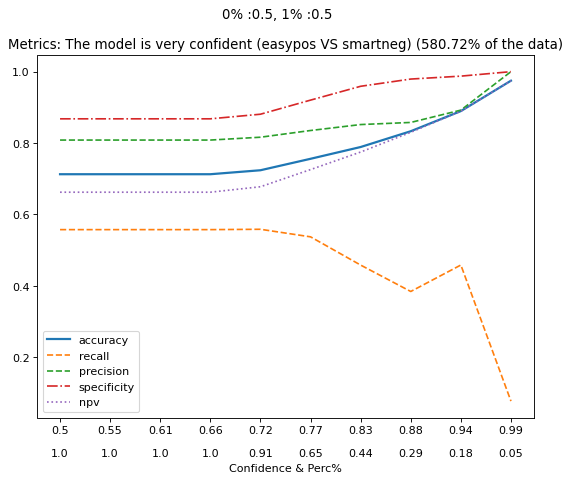

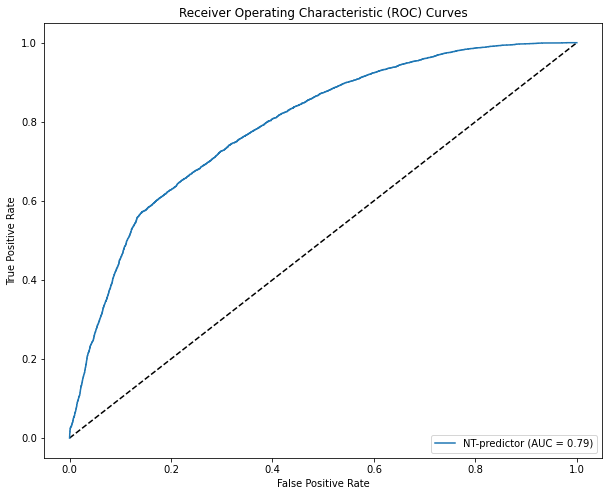

In [35]:
confidence_level = 0.7
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(balance_df(high_prob_pairs), n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

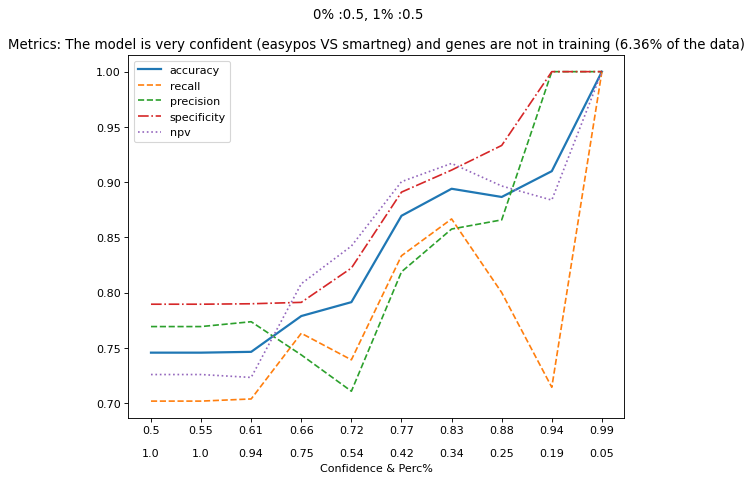

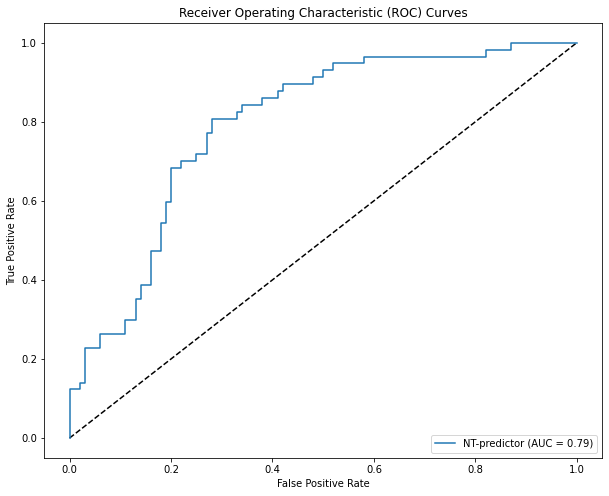

In [36]:
confidence_level = 0.6
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(balance_df(high_prob_pairs), n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

In [37]:
# sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
# sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
# plt.title(f'Length distribution')
# plt.legend()

# Compare with INTARNA

In [ ]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'RANDOM', 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [14]:
intarna = intarna.dropna()

In [15]:
intarna

id1  start1  end1          id2  start2  end2  \
0     361026_rna1     427   433  361026_rna2      99   105   
1     356103_rna1      94   127  356103_rna2      22    53   
2     367319_rna1     179   192  367319_rna2     258   273   
3     374124_rna1      53    61  374124_rna2     142   150   
4     362152_rna1     470   493  362152_rna2      32    55   
...           ...     ...   ...          ...     ...   ...   
4474  365298_rna1     235   383  365298_rna2     193   340   
4475  336479_rna1     252   400  336479_rna2     238   386   
4476  347587_rna1     205   352  347587_rna2      47   196   
4477  363524_rna1     273   420  363524_rna2      93   239   
4478  374724_rna1     328   475  374724_rna2     114   261   

                                               subseqDP  \
0                                       CAUUCUU&AAGAAUG   
1     ACAGCAGCCAGCAGAGAGAAGCCGGAACCUGAGC&GCUCAGGUCGC...   
2                       UGGCAUCUAUAUCA&UGGUGUAUUAGUGCCA   
3                                   UUCUGAAGC&GCUUCAGGA   
4     CUAGAACACGCUUCAAAGCUGCCU&AGGUAGCAAUGUCUAUAGUUUUGG   
...                                                 ...   
4474  CCAGCCUGGCCAGUAUGGUGAAACCCUGUCUCUACUAAAAAUACAA...   
4475  CAGGAGUUUGAGACCAGCCUGGCCAAUAUGGUGAAACCCUGUCUCU...   
4476  ACUUUGGGAGGCUGAGGCGGGCAGAUCACGAGGUCAGAAGUUUGAG...   
4477  CUCCUGUCUCAGCCUCCCGAGUACCUGGGACUACCGGUGCCUGUCU...   
4478  UCCCACAUUAUUCCUGAUACCACACCUGACCCCCAUGACUGCAUCU...   

                                               hybridDP       E     E_norm  \
0                                       (((((((&)))))))   -2.03  -0.182435   
1     ((((..((((.(((......(((((.((((((((&))))))))......   -4.19  -0.397832   
2                       ((((((.(((((((&)))))))...))))))   -5.84  -0.469861   
3                                   (((((((((&)))))))))   -5.95  -0.478711   
4     (((((((......((..(((((((&)))))))..))......)))))))   -6.04  -0.485952   
...                                                 ...     ...        ...   
4474  ((((((((((((((((((((((((((((((.(((((((((((((((... -160.39 -12.904300   
4475  ((((((((((((((((((((((((((((((((((((((((((((((... -166.21 -13.372500   
4476  (((((((((((((((((((.((.((((((((((((((.((((((((... -169.83 -13.663800   
4477  (((((((((((((((((((((((.((((((((((.((((((((((.... -189.26 -15.227000   
4478  (((((((((((((((((((((((((((((((((((((((((.((((... -206.42 -16.607600   

                          key  couples  
0     361026_rna1_361026_rna2   361026  
1     356103_rna1_356103_rna2   356103  
2     367319_rna1_367319_rna2   367319  
3     374124_rna1_374124_rna2   374124  
4     362152_rna1_362152_rna2   362152  
...                       ...      ...  
4474  365298_rna1_365298_rna2   365298  
4475  336479_rna1_336479_rna2   336479  
4476  347587_rna1_347587_rna2   347587  
4477  363524_rna1_363524_rna2   363524  
4478  374724_rna1_374724_rna2   374724  

[4479 rows x 12 columns]

In [16]:
res

Unnamed: 0                                couples  gene1_pc  gene2_pc  \
0               0        ENSG00000111788_ENSG00000143195     False      True   
1               1        ENSG00000111788_ENSG00000143195     False      True   
2               2     ENSG00000111788_ENSMUSG00000061451     False      True   
3               3        ENSG00000111788_ENSG00000230461     False     False   
4               4        ENSG00000070770_ENSG00000198791      True      True   
...           ...                                    ...       ...       ...   
44938       44938     ENSG00000228337_ENSMUSG00000031458     False      True   
44939       44939     ENSG00000269707_ENSMUSG00000021697     False      True   
44940       44940     ENSG00000218672_ENSMUSG00000020246     False      True   
44941       44941  ENSMUSG00000009555_ENSMUSG00000080694      True     False   
44942       44942        ENSG00000119977_ENSG00000120370      True      True   

       original_length1  original_length2  id_sample  probability  \
0                  3158             13360     360169     0.425830   
1                  3158             13360     360170     0.485644   
2                  3158              4006     336169     0.016148   
3                  3158              5266     336168     0.612786   
4                  4978              6890     332240     0.307048   
...                 ...               ...        ...          ...   
44938               241               793     348117     0.295583   
44939              2093              2563     349701     0.130704   
44940              1551              3422     347839     0.005653   
44941              1733               589     351016     0.604702   
44942              2739              2189     337541     0.597257   

       ground_truth                         g1                          g2  \
0                 1     ENSG00000111788_0_3158  ENSG00000143195_6563_12533   
1                 1     ENSG00000111788_0_3158  ENSG00000143195_6123_12093   
2                 0     ENSG00000111788_0_3158   ENSMUSG00000061451_0_4006   
3                 0     ENSG00000111788_0_3158      ENSG00000230461_0_5266   
4                 1     ENSG00000070770_0_4978    ENSG00000198791_219_6189   
...             ...                        ...                         ...   
44938             0      ENSG00000228337_0_241    ENSMUSG00000031458_0_793   
44939             0     ENSG00000269707_0_2093   ENSMUSG00000021697_0_2563   
44940             0     ENSG00000218672_0_1551   ENSMUSG00000020246_0_3422   
44941             0  ENSMUSG00000009555_0_1733    ENSMUSG00000080694_0_589   
44942             0     ENSG00000119977_0_2739      ENSG00000120370_0_2189   

         policy  len_g1  len_g2  prediction  sampled_area    original_gene_id  \
0       easypos     500     500           0        250000     ENSG00000111788   
1       easypos     500     500           0        250000     ENSG00000111788   
2      smartneg     500     500           0        250000     ENSG00000111788   
3      smartneg     500     500           1        250000     ENSG00000111788   
4       easypos     500     500           0        250000     ENSG00000070770   
...         ...     ...     ...         ...           ...                 ...   
44938  smartneg     241     500           0        120500     ENSG00000228337   
44939  smartneg     500     500           0        250000     ENSG00000269707   
44940  smartneg     500     500           0        250000     ENSG00000218672   
44941  smartneg     500     500           1        250000  ENSMUSG00000009555   
44942  smartneg     500     500           1        250000     ENSG00000119977   

      specie      gene1_original      gene2_original  
0      human     ENSG00000111788     ENSG00000143195  
1      human     ENSG00000111788     ENSG00000143195  
2      human     ENSG00000111788  ENSMUSG00000061451  
3      human     ENSG00000111788     ENSG00000230461  
4      human     ENSG00000070770

In [17]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [18]:
res

Unnamed: 0                             couples  gene1_pc  gene2_pc  \
0             23     ENSG00000138326_ENSG00000218891      True      True   
1             36     ENSG00000213014_ENSG00000272473     False     False   
2             39     ENSG00000101138_ENSG00000256281      True     False   
3             43     ENSG00000167004_ENSG00000247627      True     False   
4             57  ENSG00000062485_ENSMUSG00000064351      True      True   
...          ...                                 ...       ...       ...   
4458       44910  ENSG00000171492_ENSMUSG00000021079      True      True   
4459       44926  ENSG00000228748_ENSMUSG00000016984     False      True   
4460       44931  ENSG00000203867_ENSMUSG00000038729      True      True   
4461       44934     ENSG00000163064_ENSG00000224427      True     False   
4462       44940  ENSG00000218672_ENSMUSG00000020246     False      True   

      original_length1  original_length2  id_sample  probability  \
0                 2712              2922     340452     0.667356   
1                  832               861     347662     0.521456   
2                 4032               294     334007     0.471738   
3                 3680              1377     344263     0.635236   
4                 3057              1545     331880     0.662583   
...                ...               ...        ...          ...   
4458              3950              2564     344977     0.170747   
4459              2028              4185     348137     0.601784   
4460              7293              7231     369178     0.099805   
4461              2427               316     343466     0.286705   
4462              1551              3422     347839     0.005653   

      ground_truth                         g1  ... len_g1 len_g2  prediction  \
0                1     ENSG00000138326_0_2712  ...    500    500           1   
1                0      ENSG00000213014_0_832  ...    500    500           1   
2                0     ENSG00000101138_0_4032  ...    500    294           0   
3                0     ENSG00000167004_0_3680  ...    500    500           1   
4                0     ENSG00000062485_0_3057  ...    500    500           1   
...            ...                        ...  ...    ...    ...         ...   
4458             0     ENSG00000171492_0_3950  ...    500    500           0   
4459             0     ENSG00000228748_0_2028  ...    500    500           1   
4460             0  ENSG00000203867_1079_7049  ...    500    500           0   
4461             0     ENSG00000163064_0_2427  ...    500    316           0   
4462             0     ENSG00000218672_0_1551  ...    500    500           0   

      sampled_area  original_gene_id  specie   gene1_original  \
0           250000   ENSG00000138326   human  ENSG00000138326   
1           250000   ENSG00000213014   human  ENSG00000213014   
2           147000   ENSG00000101138   human  ENSG00000101138   
3           250000   ENSG00000167004   human  ENSG00000167004   
4           250000   ENSG00000062485   human  ENSG00000062485   
...            ...               ...     ...              ...   
4458        250000   ENSG00000171492   human  ENSG00000171492   
4459        250000   ENSG00000228748   human  ENSG00000228748   
4460        250000   ENSG00000203867   human  ENSG00000203867   
4461        158000   ENSG00000163064   human  ENSG00000163064   
4462        250000   ENSG00000218672   human  ENSG00000218672   

          gene2_original      E    E_norm  
0        ENSG00000218891 -19.79 -1.592220  
1        ENSG00000272473 -13.90 -1.118330  
2        ENSG00000256281 -17.74 -1.490980  
3        ENSG00000247627 -17.27 -1.389470  
4     ENSMUSG00000064351 -11.07 -0.890643  
...                  ...    ...       ...  
4458  ENSMUSG00000021079 -11.97 -0.963053  
4459  ENSMUSG00000016984 -15.51 -1.247870  
4460  ENSMUSG00000038729 -11.75 -0.945353  
4461     ENSG00000224427 -15.27 -1.275650  
4462  ENSMUSG00000020246 -25.79 -2.074950  

[4463

In [19]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [20]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.7020466519143514 0.5362686945519922


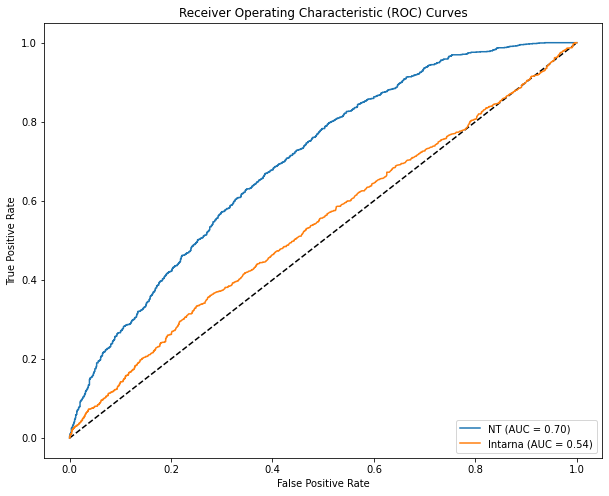

In [21]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

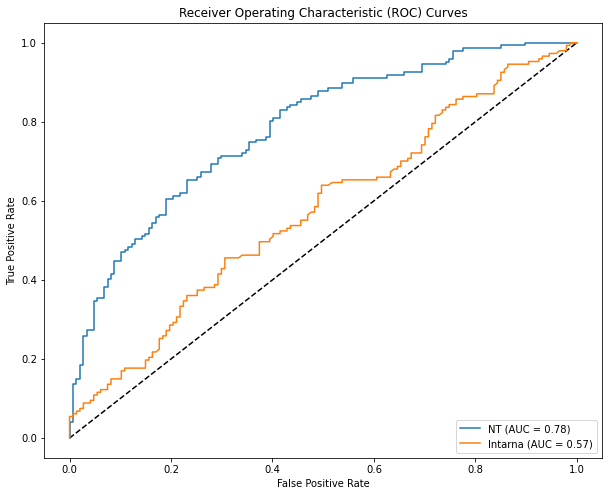

In [171]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

In [ ]:
test = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'val_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

In [ ]:
def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = False)
    aucs_nt.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = True)
    aucs_intarna.append(roc_auc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

#### Compare AUC based on confidence

In [ ]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

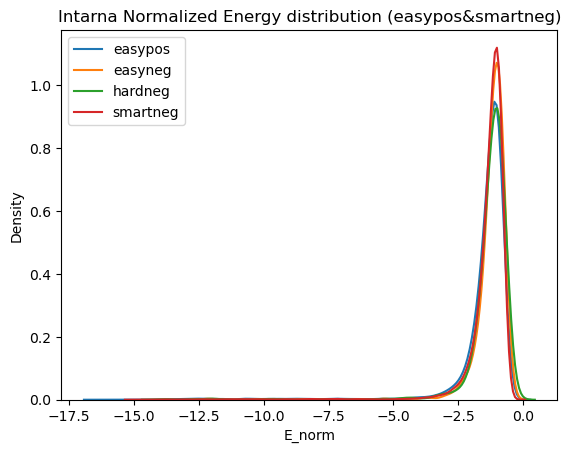

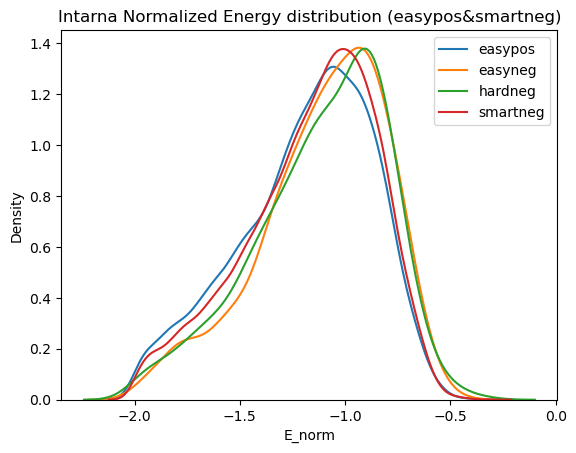

In [71]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [175]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

In [ ]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.01)

perc of the total data:  8.9 %


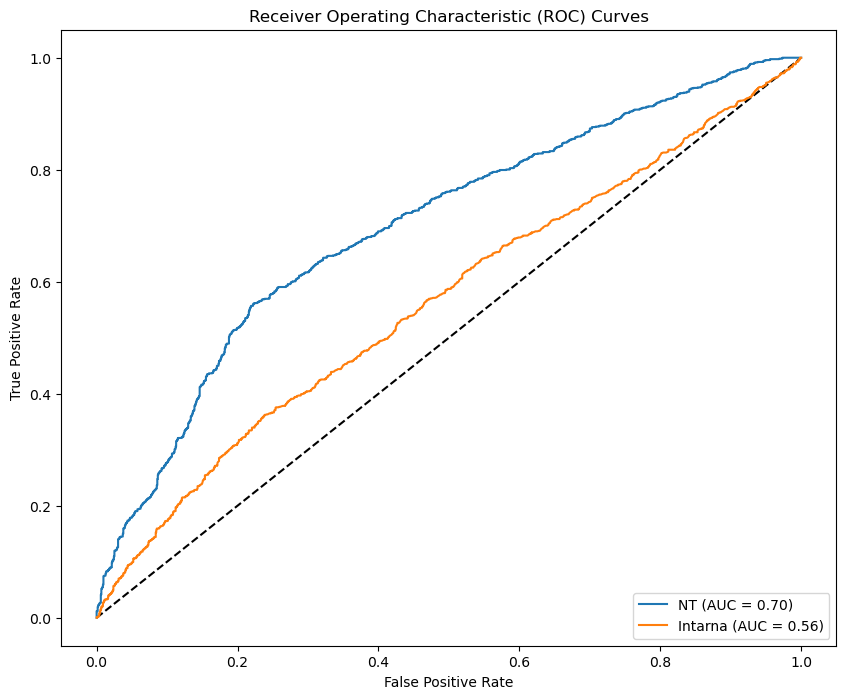

In [74]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

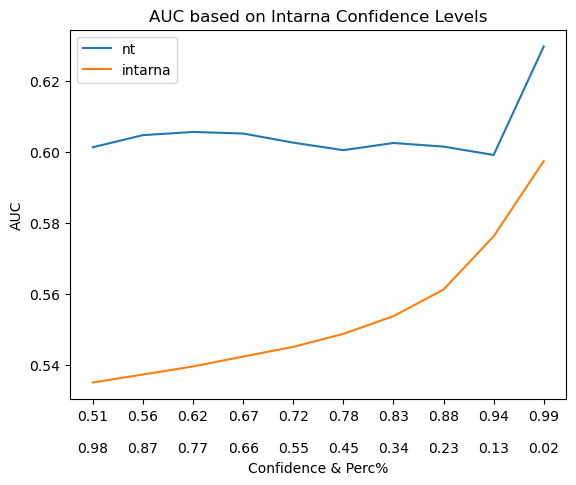

In [75]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

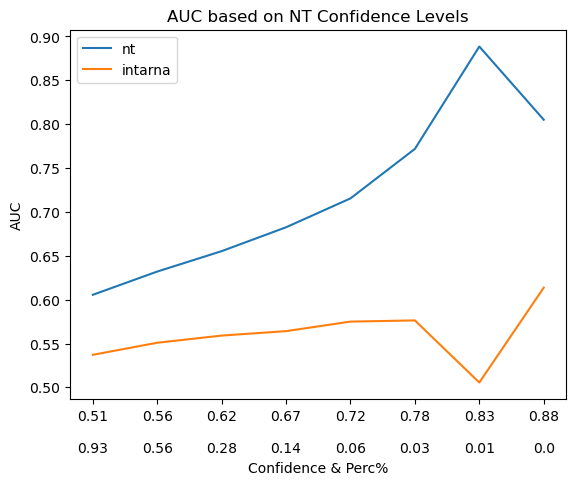

In [76]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

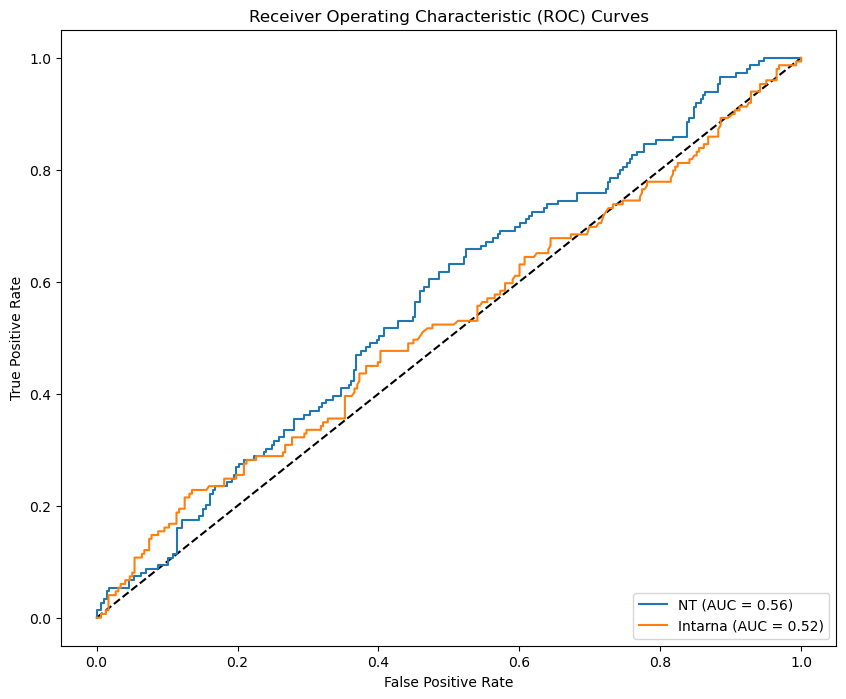

In [77]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [78]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [79]:
subset_where_disagree.ground_truth.value_counts()

0    1347
1    1187
Name: ground_truth, dtype: int64

Text(0.5, 0, 'Confidence & Perc%')

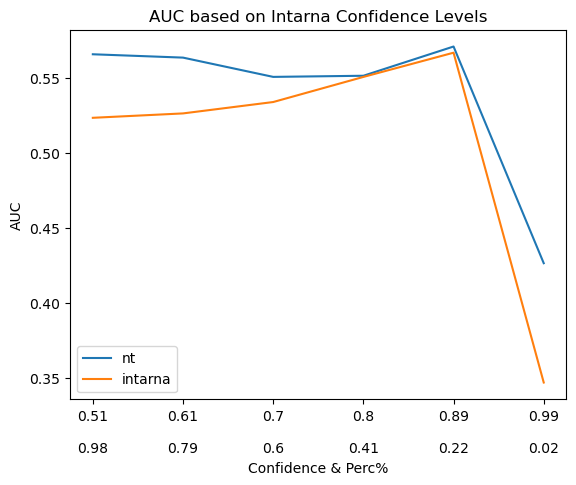

In [80]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'intarna', n_values = 6)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

In [81]:
confidence_space = np.linspace(0.51, 0.99, 6)
for i in range(6):
    treshold = 1-confidence_space[i]
    subset = not_in_train_epsn[
        (not_in_train_epsn.E_norm <= not_in_train_epsn.E_norm.quantile(treshold))|
        (not_in_train_epsn.E_norm >= not_in_train_epsn.E_norm.quantile(1-treshold))
    ]
fpr, tpr, _ = roc_curve(abs(1 - subset.ground_truth), subset.E_norm)
roc_auc = auc(fpr, tpr)
roc_auc

0.3468543046357616

Text(0.5, 0, 'Confidence & Perc%')

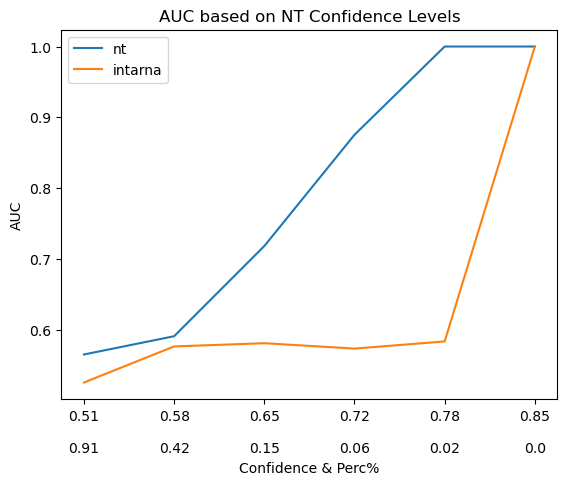

In [82]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'nt', n_values = 8)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

# XAI

In [56]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt.csv'))

DEVICE = 'cuda'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 400, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(o

In [57]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500.csv'))

In [58]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [59]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0048
iou_value_tr: 0.0044
iou_value_rand: 0.0029


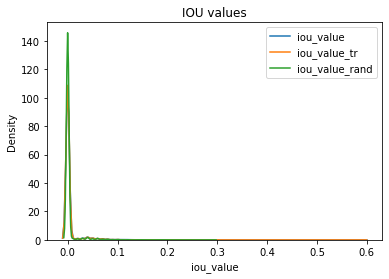

intensity: 0.5868
intensity_tr: 0.1831
intensity_rand: 0.5001


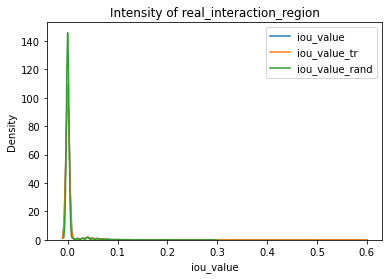

euclidean: 0.481
euclidean_rand: 0.5244
euclidean_bbox_tr: 0.509


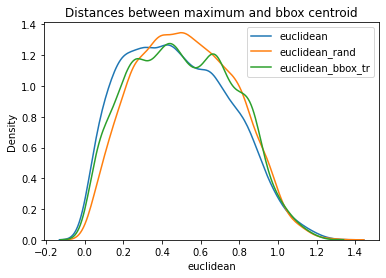

cos_sim: 0.05
cos_sim_tr: 0.03
cos_sim_rand: 0.04


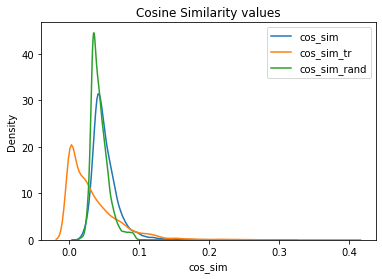

In [60]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [61]:
df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.4089
euclidean_rand: 0.644


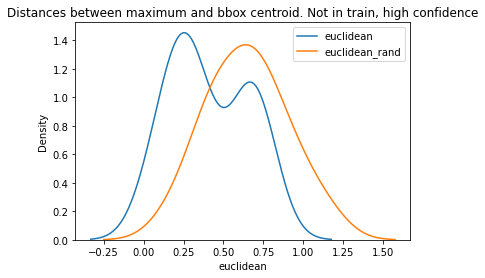

In [62]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [63]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.4209
euclidean_rand: 0.5273


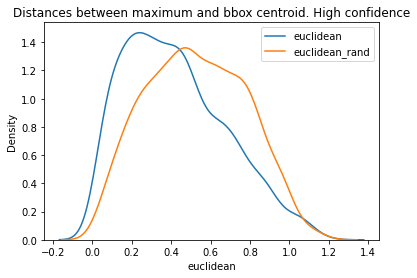

In [64]:
gradcam_results = xai[(xai.probability>0.75)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

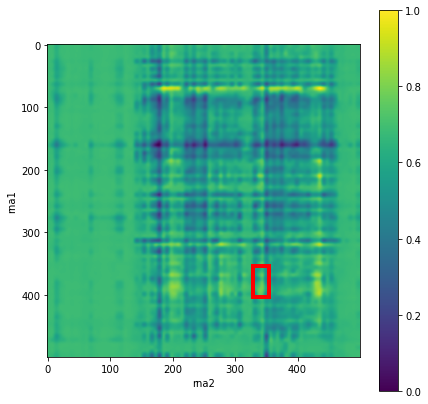

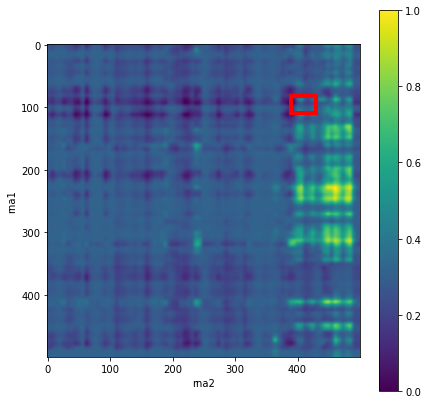

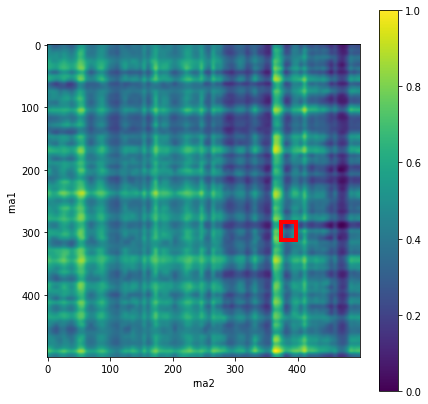

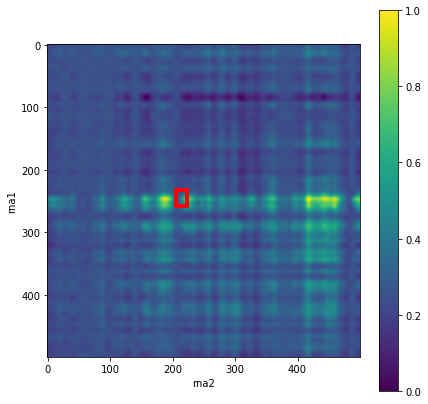

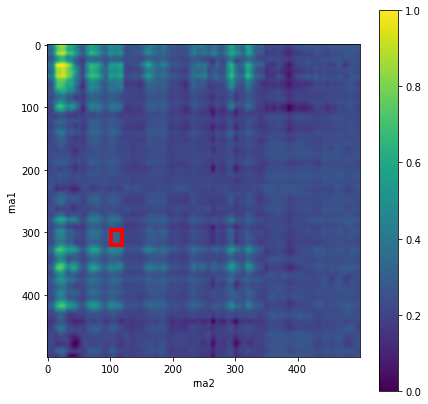

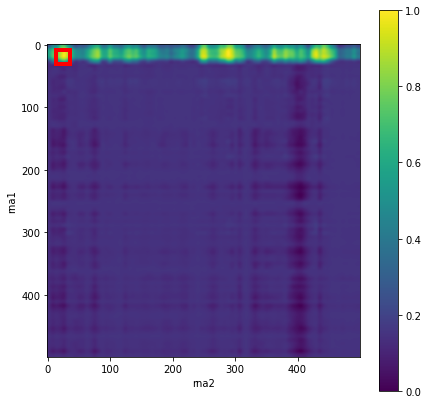

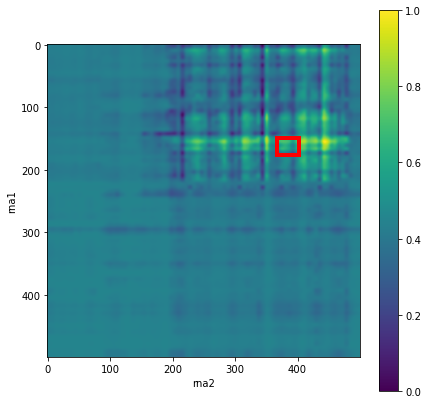

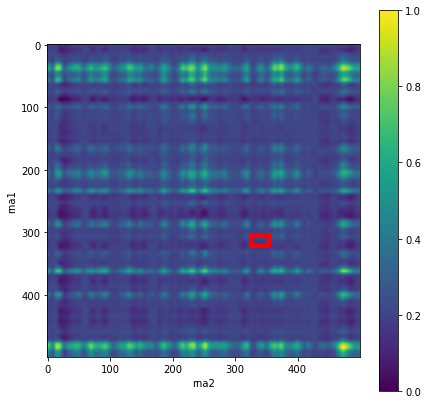

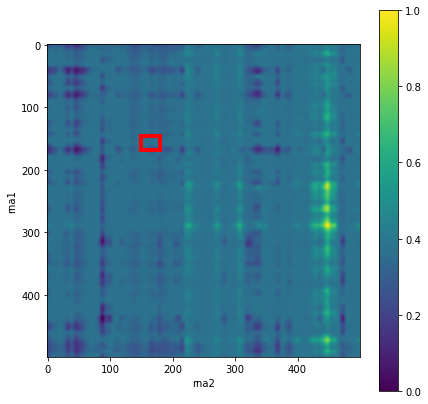

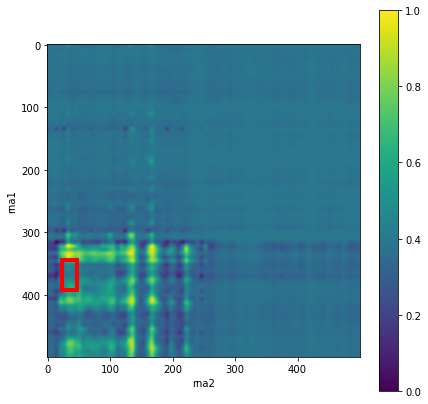

In [66]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query.sample(10))

Not in training

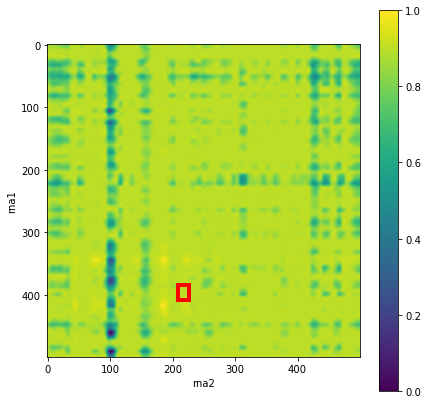

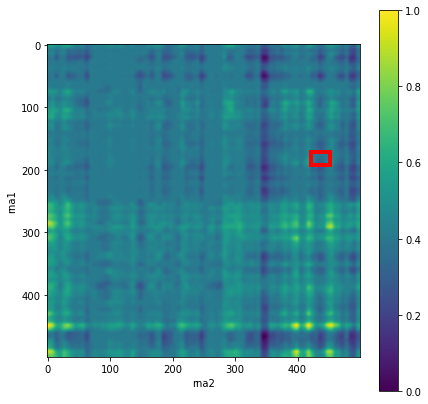

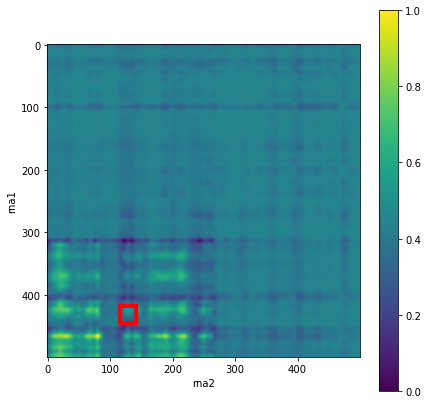

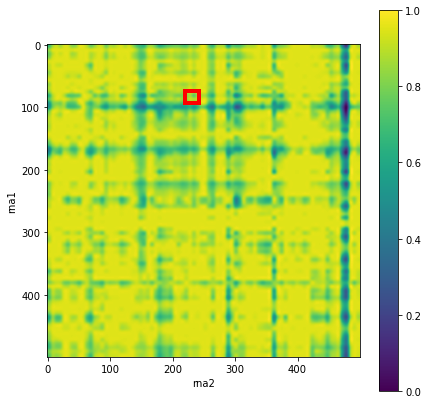

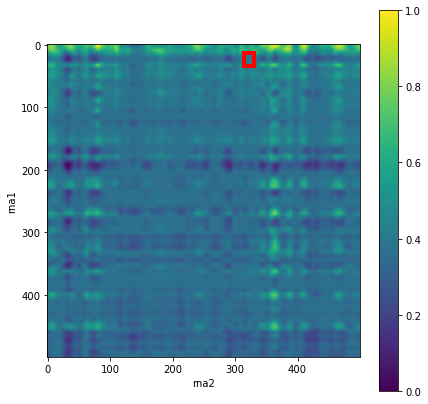

In [68]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(5))

High confidence not in train

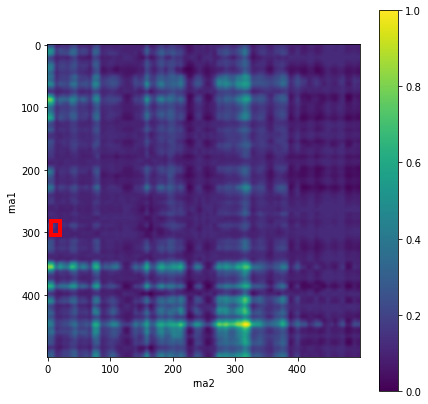

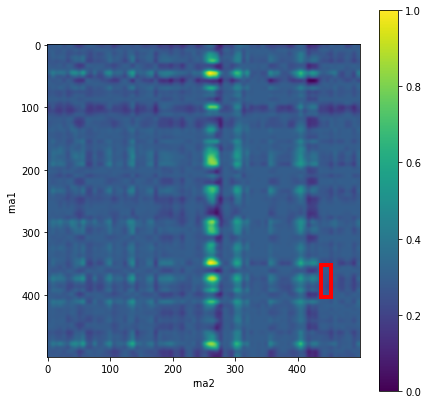

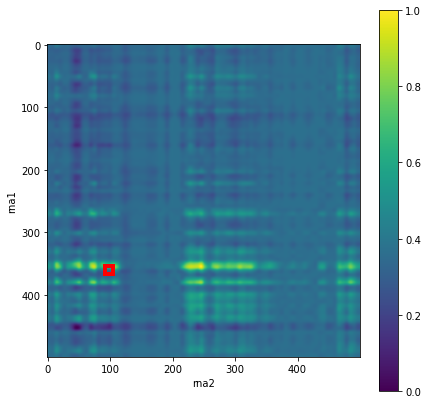

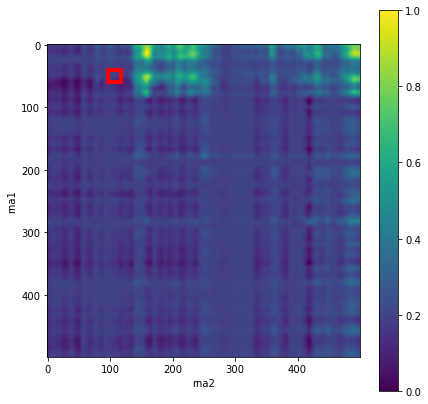

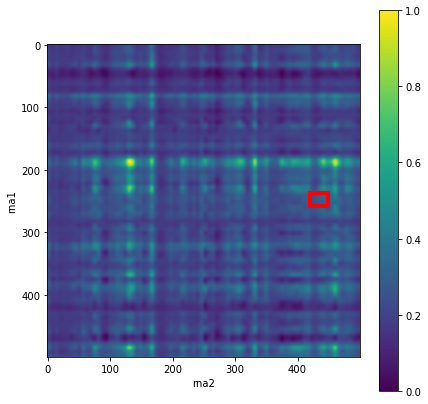

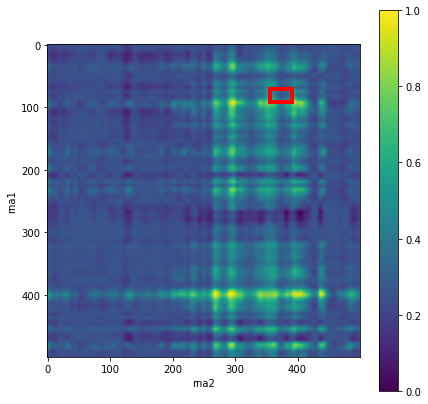

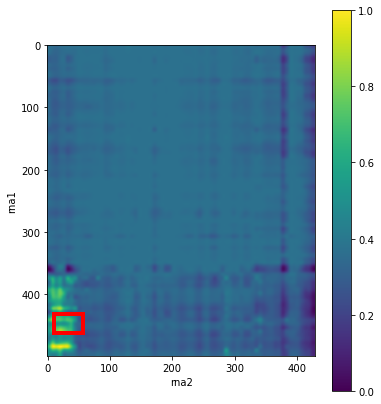

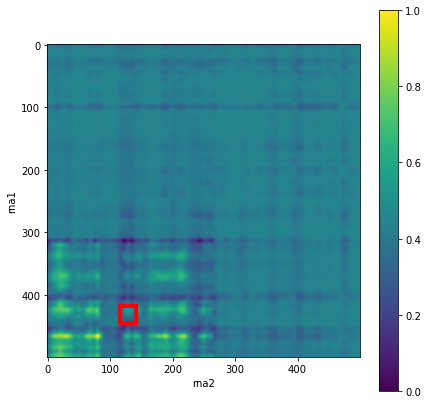

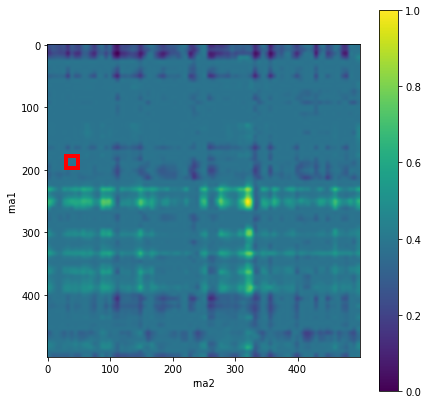

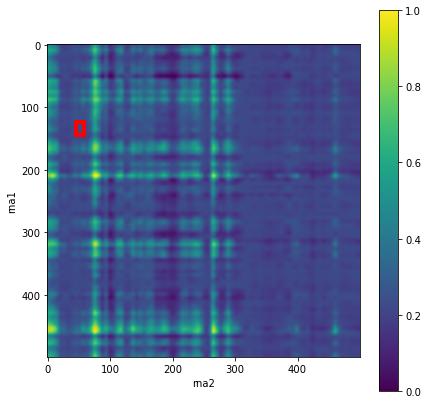

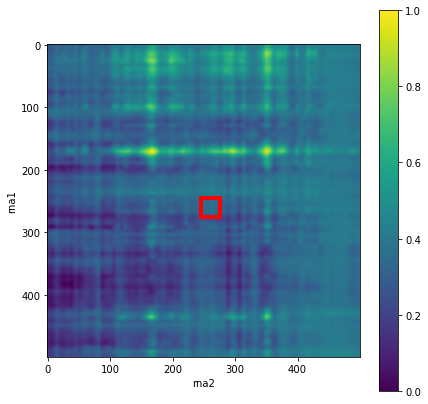

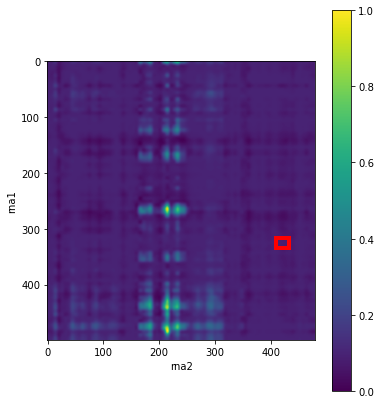

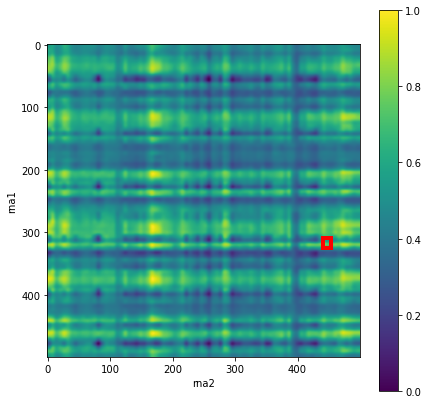

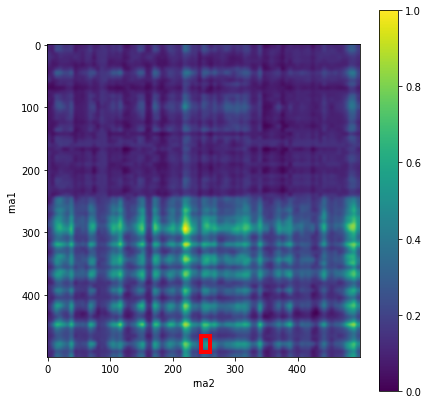

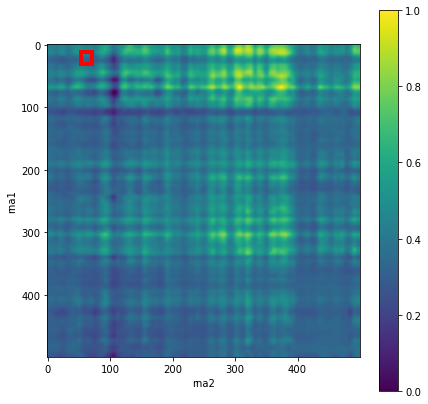

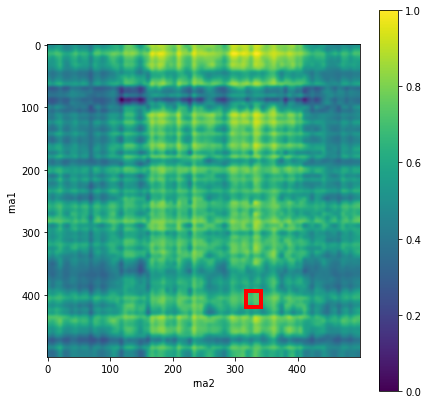

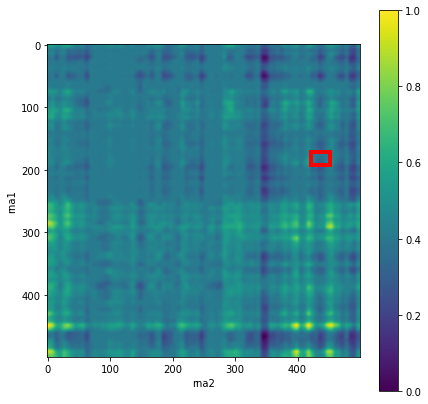

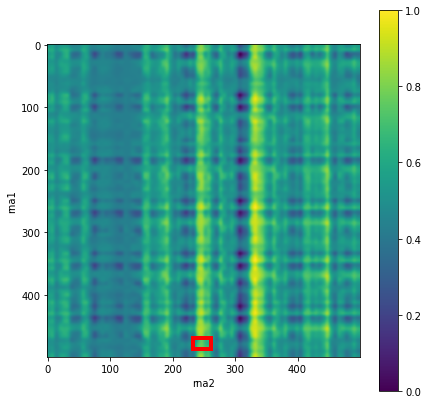

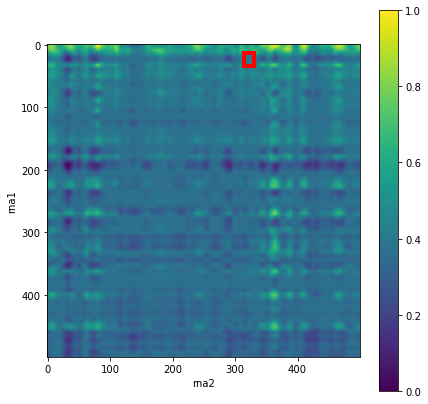

In [228]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.7)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(25))

False Negatives

In [225]:
# gradcam_results = xai
# gradcam_results = gradcam_results[(gradcam_results.probability<0.5)]

# query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
# query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

# plot_query_results(query.sample(10))

False Negatives, not in train, almost 0.5

In [227]:
# gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
# gradcam_results = gradcam_results[(gradcam_results.probability<0.5)&((gradcam_results.probability>0.48))]

# query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
# query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
# query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

# plot_query_results(query.head(10))

In [23]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'val_results500.csv'))

# Drop all the pairs (they should be 60-70) that are present in the training set.
res = res[~res.couples.isin(gene_pairs_train_original)]

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     30471
           1       0.47      0.54      0.50     14373

    accuracy                           0.66     44844
   macro avg       0.62      0.63      0.62     44844
weighted avg       0.67      0.66      0.66     44844



In [71]:
EXP = 'PARIS1' #can be 'PARIS1', 'PARIS2'
N_READS = 1


#OBTAIN High Quality Reads
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )

all_interactions = all_interactions[~all_interactions.experiment.isin(['hs_RIC-seq__HeLa_merge.InterGene.arms', 'mm_MARIO__mES'])] #take only paris

all_interactions[['x1', 'x2', 'y1', 'y2', 'n_reads']] = all_interactions[['x1', 'x2', 'y1', 'y2', 'n_reads']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}


#all_interactions = all_interactions.loc[(all_interactions['name'].str.count('PARIS1')>0)&(all_interactions['n_reads']>1)]
all_interactions = all_interactions.loc[(all_interactions['name'].str.count(EXP)>0)]


info = pd.read_csv(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), sep = '\t')
merged = all_interactions.merge(info, on = 'name')

assert (merged.tr1 == merged.chrom_1).all()
assert (merged.tr2 == merged.chrom_2).all()
assert (merged.x1 == merged.start_1).all()
assert (merged.x2 == merged.end_1).all()
assert (merged.y1 == merged.start_2).all()
assert (merged.y2 == merged.end_2).all()
assert (merged.strand_1 == merged.strand_2).all()
assert set(merged.strand_1) == {'+'}

merged = merged.drop(['Unnamed: 0','chrom_1', 'chrom_2', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2',
             'score', 'external_gene_name_1', 'external_gene_name_2', 'chrom_1_localization', 'chrom_2_localization', 
            'gene_biotype_1', 'gene_biotype_2'], axis = 1)


def get_couple_id(g1, g2, needed_to_swap = False):
    l = sorted([g1, g2])
    if needed_to_swap:
        need_to_swap = False if l[0] == g1 else True
        return '_'.join(l), need_to_swap
    else:
        return '_'.join(l)

    
hq_reads = merged[merged.n_reads>N_READS][['ensembl_gene_id_1', 'ensembl_gene_id_2']].apply(lambda x: get_couple_id(x.ensembl_gene_id_1, x.ensembl_gene_id_2), axis = 1)
hq_reads = set(hq_reads)

subset_hq_reads = res[res.couples.isin(hq_reads)]

subset_hq_reads = subset_hq_reads[subset_hq_reads.policy.isin(['easypos'])]

n_hq_reads = subset_hq_reads.shape[0]
print('# of high quality reads positive samples:', n_hq_reads)
print('accuracy on positive class over high quality reads:', (subset_hq_reads.prediction == subset_hq_reads.ground_truth).sum()/n_hq_reads)

# of high quality reads positive samples: 56
accuracy on positive class over high quality reads: 0.5892857142857143
